In [1]:
from src.consts import IN_COLAB, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import matplotlib.pyplot as plt
import torch
import numpy as np
import logging
import datetime
from torchio import RandomAffine, Compose, ZNormalization

import src.dataset.oars_labels_consts as OARS_LABELS
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview
from src.dataset.get_cut_lists import get_cut_lists
from src.dataset.get_full_res_cut import get_full_res_cut
from src.dataset.get_dataset import get_dataset
from src.dataset.get_dataset_info import get_dataset_info
from src.dataset.preview_dataset import preview_dataset
from src.dataset.get_dataset_transform import get_dataset_transform
from src.model_and_training.prepare_model import prepare_model
from src.model_and_training.train_loop import train_loop
from src.model_and_training.show_model_info import show_model_info
from src.model_and_training.load_checkpoint_model_info import load_checkpoint_model_info
from src.helpers.show_cuda_usage import show_cuda_usage
from src.helpers.get_rescaled_pred import get_rescaled_preds
from src.dataset.split_dataset import split_dataset, copy_split_dataset
from src.helpers.compare_prediction_with_ground_true import compare_prediction_with_ground_true, compare_one_prediction_with_ground_true
from src.helpers.get_img_outliers_pixels import get_img_outliers_pixels
from src.helpers.get_raw_with_prediction import get_raw_with_prediction

from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets

torch.manual_seed(20)
logging.basicConfig(filename='logs/precourse_neural_network.log', level=logging.DEBUG)


TRAIN_LOW_MODEL=False
TRAIN_CUT_MODEL=False

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Low resolution NN

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
print('low res dataset RAM sizes in GB', low_res_dataset.get_data_size() / 1024**3)

low_res_split_dataset_obj = split_dataset(low_res_dataset, train_size=40, valid_size=5, test_size=5)
get_dataset_info(low_res_dataset, low_res_split_dataset_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(low_res_split_dataset_obj)

CUDA using 16x dataset
filtering labels
filtering labels done
dilatating 1x dataset
parsing dataset to numpy
numpy parsing done
data type: int16 int8
low res dataset RAM sizes in GB 0.02288818359375
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 3071, min -1024
label max 1, min 0


Output()

## training low res model

In [4]:
if TRAIN_LOW_MODEL:
    # preparing model loop params
    low_res_model_info = prepare_model(epochs=500, 
                                       learning_rate=3e-4,
                                       in_channels=4,
                                       input_data_channels=1,
                                       output_label_channels=1,
                                       dropout_rate=0.2,
                                       train_batch_size=4,
                                       train_dataset=train_low_res_dataset, 
                                       valid_dataset=valid_low_res_dataset, 
                                       test_dataset=test_low_res_dataset)
    show_model_info(low_res_model_info)

    # running training loop
    train_loop(low_res_model_info)
else:
    epoch = 500
    log_date = datetime.datetime(year=2020, month=10, day=27, hour=11, minute=45, second=30).strftime("%Y%m%d-%H%M%S")
    model_name = f'{log_date}_3d_unet_PRECOURSE'

    loaded_model_info = load_checkpoint_model_info(model_name, epoch, train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset)
    show_model_info(loaded_model_info)

    low_res_model_info = loaded_model_info

Model number of params: 298881, trainable 298881


/home/nikolas/fiit-dp-thesis-code/venv/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'src.losses.dice_loss.DiceLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Full resolution cutting

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
filtering labels
filtering labels done
parsing dataset to numpy
numpy parsing done
data type: int16 int8
data max 3071, min -1024
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## Testing low res network


### getting bounding box cut in full res

In [6]:
full_res_split_dataset_obj = copy_split_dataset(full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(full_res_dataset, full_res_split_dataset_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [7]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model_info['device'] = 'cpu'
low_res_model_info['model'] = low_res_model_info['model'].to(low_res_model_info['device'])
low_res_model_info['model'].eval()
torch.cuda.empty_cache()
print('moved model to cpu')

show_cuda_usage()

moved model to cpu
CUDA Memory Usage
GPU:        GeForce RTX 2070
Allocated:  0.0 GB
Cached:     0.0 GB
Max memory: 0.0 GB
Max Cached: 0.0 GB


/home/nikolas/fiit-dp-thesis-code/venv/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/home/nikolas/fiit-dp-thesis-code/venv/lib/python3.8/site-packages/torch/cuda/memory.py:352: FutureWarning: torch.cuda.max_memory_cached has been renamed to torch.cuda.max_memory_reserved
  warnings.warn(


get_full_res_cut: Removing 0/1567 outlier pixels
get_final_bounding_box_slice: box delta [21 32  8]
get_full_res_cut: Does cut and original label contain the same amount of pixels? True 1731533 1731533
get_full_res_cut: Bounding box sizes (51, 160, 160) (72, 192, 168)
get_full_res_cut: Bounding boxes (53, 103, 176, 335, 176, 335) (43, 114, 160, 351, 172, 339)


Output()

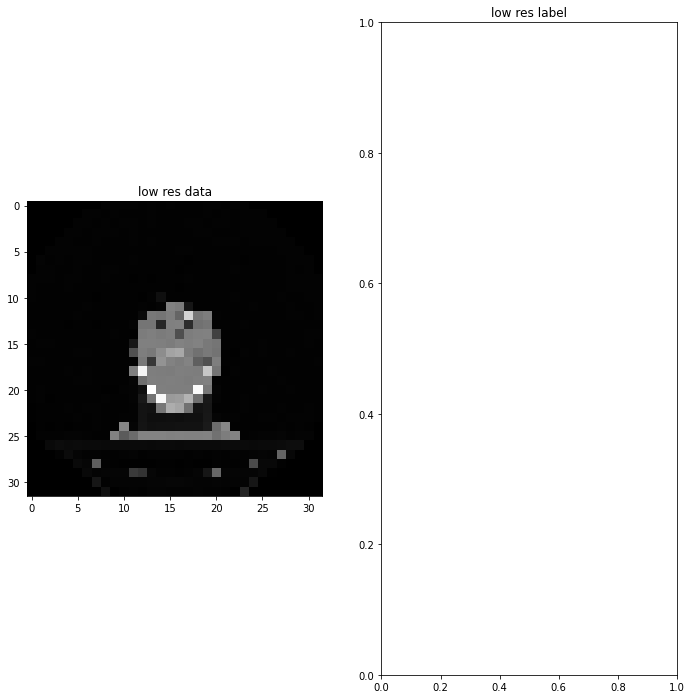

Output()

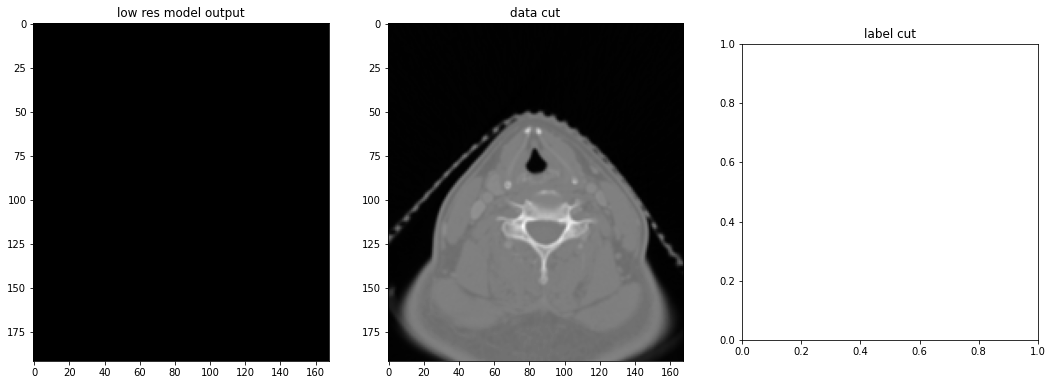

In [9]:
dataset_index = 38

raw_low_data =  low_res_dataset.data_list[dataset_index]
raw_low_label = low_res_dataset.label_list[dataset_index]
raw_full_data = full_res_dataset.data_list[dataset_index]
raw_full_label = full_res_dataset.label_list[dataset_index]

tmp = get_full_res_cut(low_res_model=low_res_model_info['model'],
                       low_res_device=low_res_model_info['device'],
                       raw_low_res_data_img=raw_low_data,
                       raw_low_res_label_img=raw_low_label,
                       raw_full_res_data_img=raw_full_data, 
                       raw_full_res_label_img=raw_full_label,
                       low_res_mask_threshold=0.5,
                       desire_bounding_box_size=DESIRE_BOUNDING_BOX_SIZE, 
                       show_debug=True)

## Running cut algorithm, creating cut dataset

In [ ]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model_info['model'], low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

In [ ]:
cut_full_res_dataset.set_output_label(None)
print(cut_full_res_dataset.transform)
preview_dataset(cut_full_res_dataset, preview_index=0, show_hist=False)

### reviewing full res and cut dataset

In [ ]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset[0][0].shape, full_res_dataset[1][0].shape)
print('cut full res shape', cut_full_res_dataset[0][0].shape, cut_full_res_dataset[1][0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, preview_index=2)

# Full resolution cut model

## Preparing cut dataset

In [ ]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_split_dataset_obj = copy_split_dataset(cut_full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(cut_full_res_dataset, cut_split_dataset_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(cut_split_dataset_obj)

## Training Cut Model

In [ ]:
if TRAIN_CUT_MODEL:
    cut_model_info = prepare_model(epochs=100,
                                   learning_rate=3e-4,
                                   in_channels=8,
                                   input_data_channels=1,
                                   output_label_channels=1,
                                   dropout_rate=0.2,
                                   train_batch_size=2,
                                   train_dataset=cut_train_dataset, 
                                   valid_dataset=cut_valid_dataset, 
                                   test_dataset=cut_test_dataset)
    show_model_info(cut_model_info)

    train_loop(cut_model_info)
else:
    epoch = 100
    log_date = datetime.datetime(year=2020, month=10, day=27, hour=14, minute=14, second=51).strftime("%Y%m%d-%H%M%S")
    model_name = f'{log_date}_3d_unet_EYES'

    loaded_model_info = load_checkpoint_model_info(model_name, epoch, cut_train_dataset, cut_valid_dataset, cut_test_dataset)
    show_model_info(loaded_model_info)
    
    # model export
    cut_model_info = loaded_model_info

160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

## Cut Model evaluation

In [ ]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
cut_model_info['device'] = 'cpu'
cut_model_info['model'] = cut_model_info['model'].to(cut_model_info['device'])
cut_model_info['model'].eval()
torch.cuda.empty_cache()
print('moved model to cpu')

show_cuda_usage()

In [ ]:
max_slices = cut_train_dataset[0][1].shape[0]

display(Markdown("### Train Eval"))
show_model_dataset_pred_preview(cut_model_info, cut_train_dataset, max_slices=max_slices, default_slice=49)

display(Markdown("### Valid Eval"))
show_model_dataset_pred_preview(cut_model_info, cut_valid_dataset, dataset_index=0, max_slices=max_slices, default_slice=53)

# display(Markdown("### Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

### Showing label prediction comparision

In [ ]:
# train
rnd_train_idx = low_res_split_dataset_obj['train_dataset'].indices[0]
print(f'Train index {rnd_train_idx}')
raw_data, raw_label, raw_prediction = get_raw_with_prediction(cut_model_info['model'], cut_full_res_dataset, cut_model_info["device"], rnd_train_idx)
compare_one_prediction_with_ground_true(raw_data,
                                        raw_label,
                                        raw_prediction,
                                        pred_threshold=0.5)

# valid
rnd_valid_idx = low_res_split_dataset_obj['valid_dataset'].indices[0]
print(f'Valid index {rnd_valid_idx}')
raw_data, raw_label, raw_prediction = get_raw_with_prediction(cut_model_info['model'], cut_full_res_dataset, cut_model_info["device"], rnd_valid_idx)
compare_one_prediction_with_ground_true(raw_data,
                                        raw_label,
                                        raw_prediction,
                                        pred_threshold=0.5)